## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_vertical_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/segmentAnything/full/wavelet/vertical/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


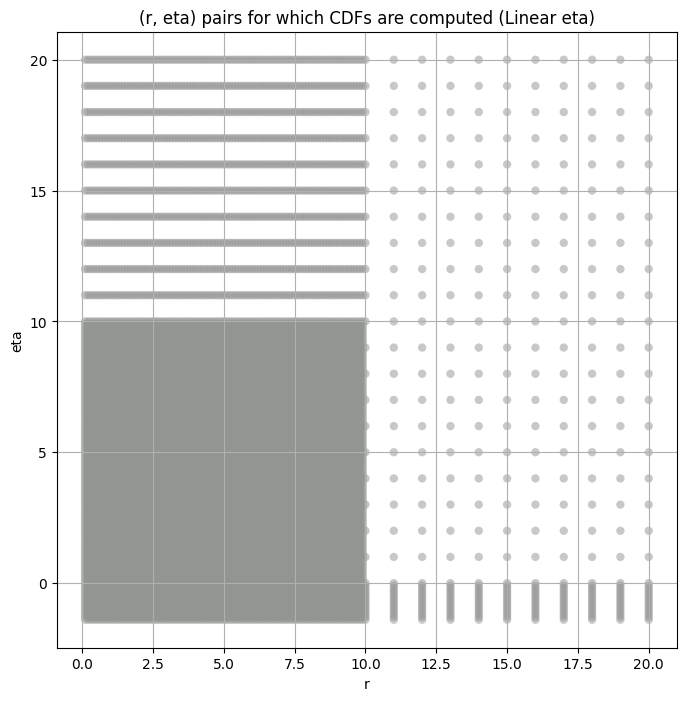

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8947.795000  8423.270000  9485.260000   1.786103    1.468954   
3      2426.993200  2289.952600  2569.244100   2.946779    2.434854   
4       662.267940   619.771800   706.498900   4.373578    3.584346   
5       169.682480   157.837700   182.347730   5.945025    4.603796   
6        40.756920    37.647247    44.079210   7.310348    5.609009   
7         9.277283     8.508139    10.167212   9.862153    6.618505   
8         2.057671     1.874289     2.295881  13.016489    7.337739   
9         0.476080     0.429436     0.549615  19.649048    8.255743   
10        0.113868     0.101202     0.135810  29.511372   10.192913   

       kurt_upper  total_samples  
layer                             
2        2.110565           7072  
3        3.534806          28288  
4        5.322586         113152  
5       10.143304         452608  
6       12.056628        1810432  
7       24.898218        7241728  
8       43.760510       28966912  
9       92.689224      115867648  
10     143.407300      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      8947.795000    8947.794922     8086.086914     7500.470215   
3      2426.993200    2426.993164     2322.521240     2252.959961   
4       662.267940     662.267944      649.186035      639.816223   
5       169.682480     169.682480      165.557846      162.824921   
6        40.756920      40.756920       39.622456       38.894806   
7         9.277283       9.277283        8.968994        8.788098   
8         2.057671       2.057671        1.977867        1.934787   
9         0.476080       0.476080        0.453927        0.443005   
10        0.113868       0.113868        0.107300        0.104226   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         7040.592285      6654.217773      6015.282715      5501.896484   
3         2194.184570      2140.925293      2048.055908      1968.130371   
4          631.508362       624.067017       610.953674       599.325684   
5          160.496094       158.402405       154.644318       151.295807   
6           38.273861        37.717957        36.725101        35.845181   
7            8.633245         8.494418         8.247649         8.029924   
8            1.898071         1.865240         1.807162         1.756075   
9            0.433771         0.425571         0.411196         0.398662   
10           0.101669         0.099424         0.095542         0.092213   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5073.167969      4702.172852      4374.527344      3562.247070  
3          1896.379150      1831.304199      1771.246948      1614.915894  
4           588.745850       578.867371       569.610413       544.742493  
5           148.254013       145.463806       142.855652       135.878418  
6            35.046360        34.310913        33.625427        31.798407  
7             7.833111         7.652325         7.484290         7.038619  
8             1.710019         1.667860         1.628836         1.526078  
9             0.387441         0.377228         0.367824         0.343273  
10            0.089270         0.086620         0.084202         0.077981

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010594429758914559 8947.795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.010593492395898296 8086.087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013254147248024317 7500.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.017935187343733783 7040.5923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.021965117549436197 6654.218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.028768286826329037 6015.2827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.035583818345180984 5501.8965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04234778756921809 5073.168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.04893522725996913 4702.173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.05533619290032332 4374.5273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.07384823515870009 3562.247
Number of samples: 7072, Without approximation : 7072


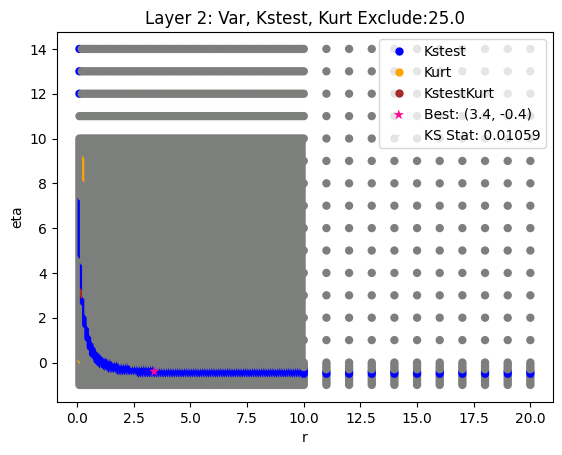

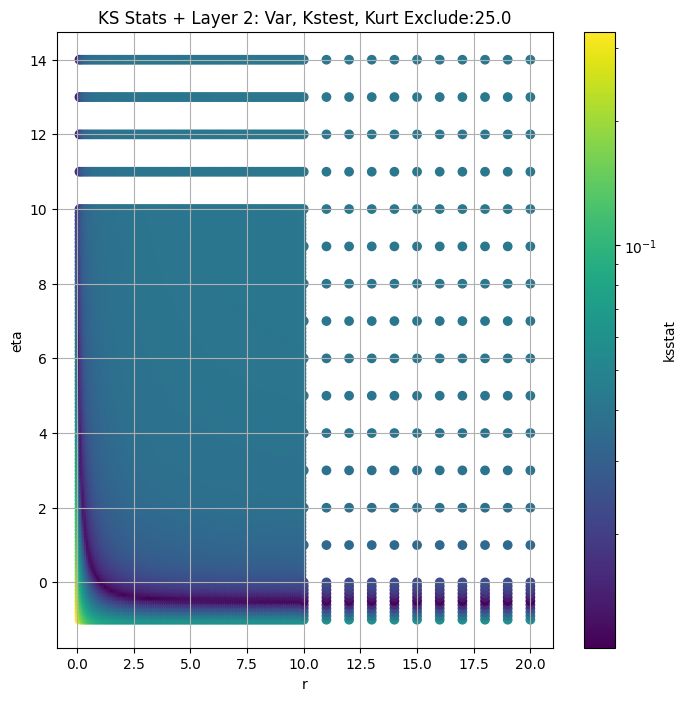

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.005256886950388895 2426.9932


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.005451618366076216 2322.5212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.005616551973327222 2252.96


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0062348280619090035 2194.1846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.0073787326431346 2140.9253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.009428042157454852 2048.056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.011289491485794056 1968.1304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01304951345784422 1896.3792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.015462860223218744 1831.3042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.017760691774930115 1771.247


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.024025754604712457 1614.9159
Number of samples: 28288, Without approximation : 28288


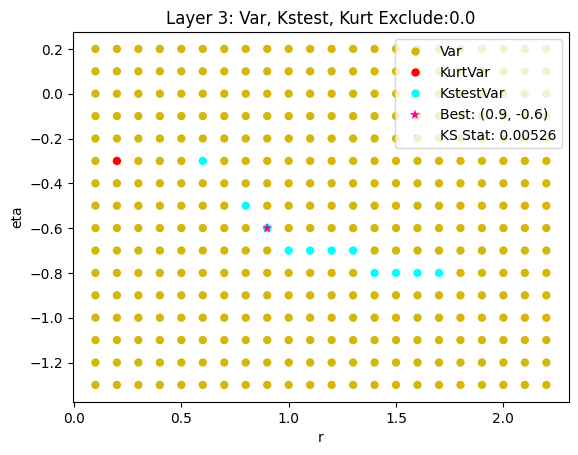

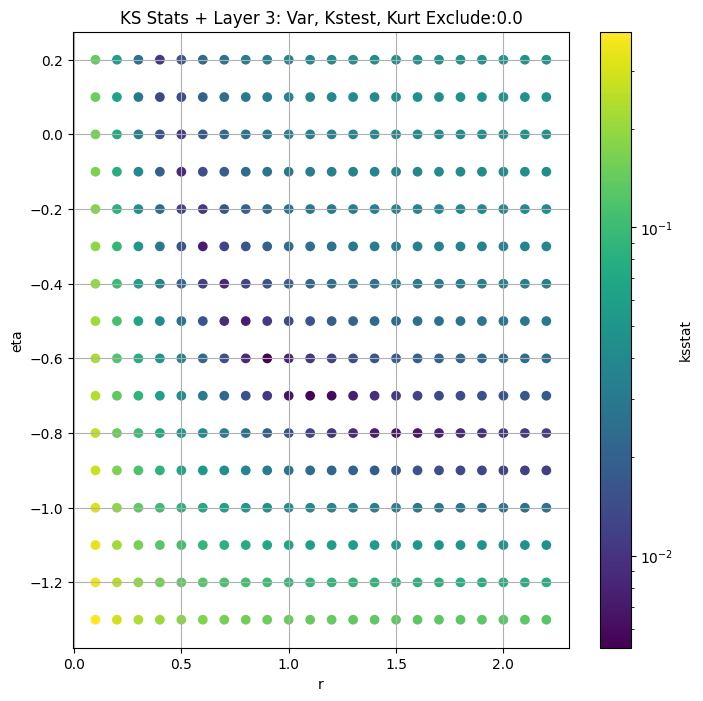

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0049262063077144536 662.26794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.005029777822312287 649.18604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.004464182771599656 639.8162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.005109395375747838 631.50836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.005064830140278143 624.067


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.005533833135983324 610.9537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.0056252797313690595 599.3257


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.006171757297117629 588.74585


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.006773564887270388 578.8674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.007394923363619375 569.6104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008806053849382822 544.7425
Number of samples: 100000, Without approximation : 113152


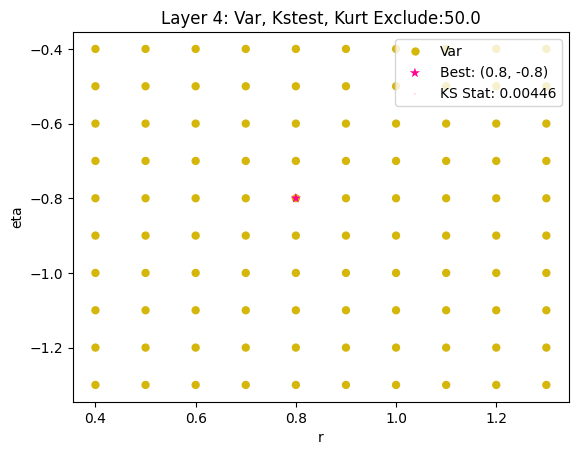

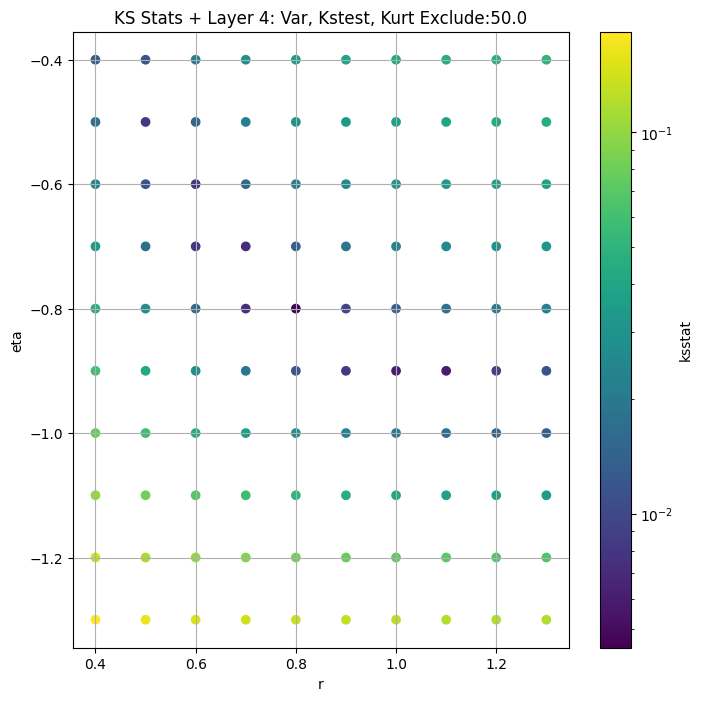

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.006332785565597854 169.68248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.004558673230634802 165.55785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.00509819669021272 162.82492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.005778043519991005 160.4961


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006393280069373453 158.4024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0069940026040531955 154.64432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0072971196314998155 151.2958


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007572615551733719 148.25401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.00783985474951393 145.4638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.008140217293012175 142.85565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009824504044481874 135.87842
Number of samples: 100000, Without approximation : 452608


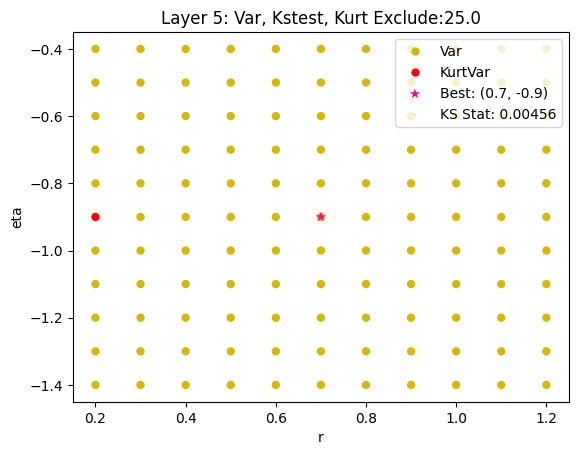

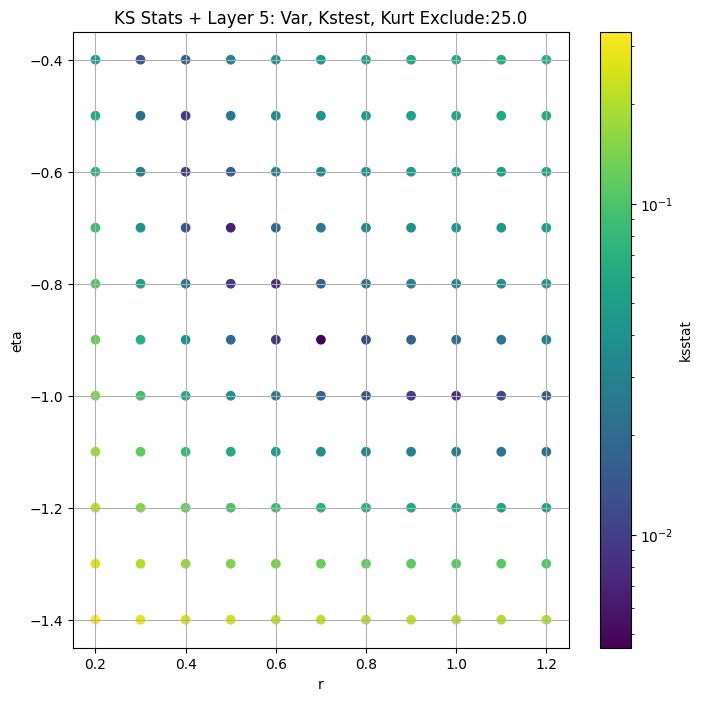

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0055478592194722065 40.75692


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.006811170419637469 39.622456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.007321415903169842 38.894806


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.00619929885987891 38.27386


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.00570033072664855 37.717957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006804133197405249 36.7251


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.007853786270776812 35.84518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.007765924715226941 35.04636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.007459600240334874 34.310913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.008214119385767438 33.625427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.009761676891059778 31.798407
Number of samples: 100000, Without approximation : 1810432


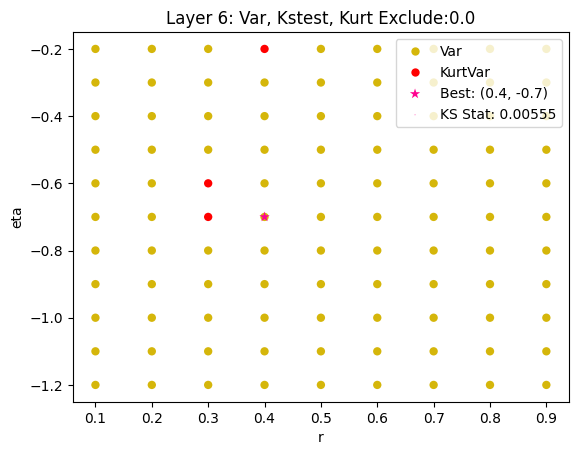

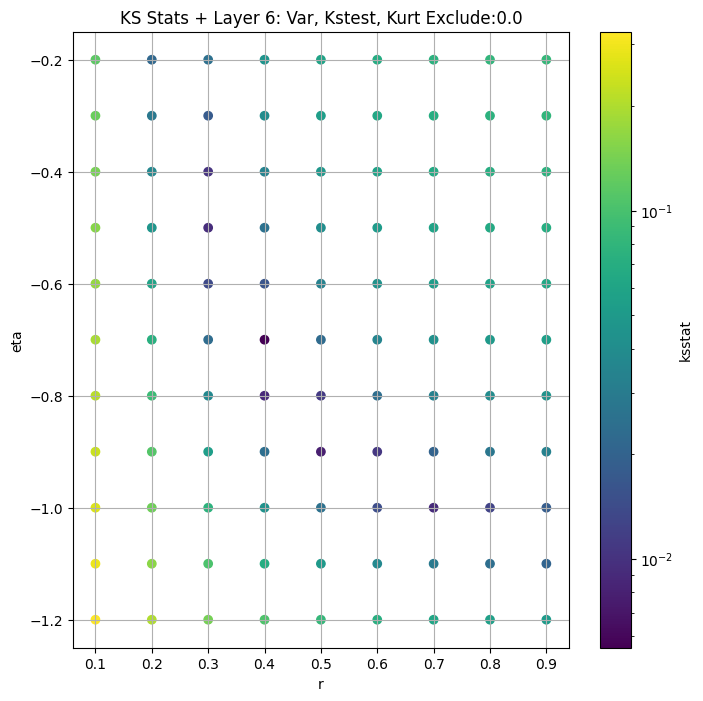

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.005659682871556659 9.277283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.006243568571388081 8.968994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.006818863115882062 8.788098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.007676371517530325 8.633245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.008212428688109619 8.494418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.008808560038704949 8.247649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.009024285141107063 8.029924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.00995198345869408 7.8331113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00844275529536298 7.6523247


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.009136886499399893 7.48429


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.009784768085441042 7.0386186
Number of samples: 100000, Without approximation : 7241728


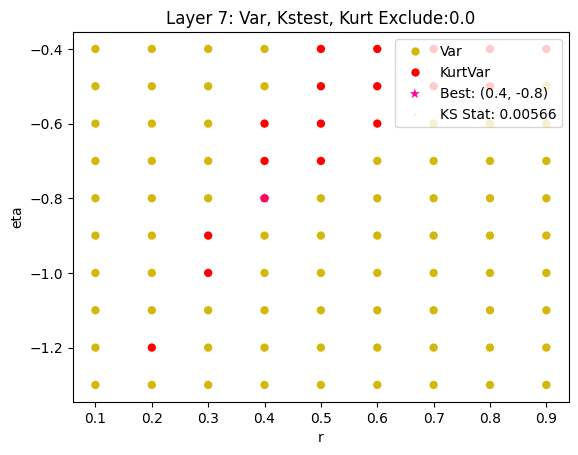

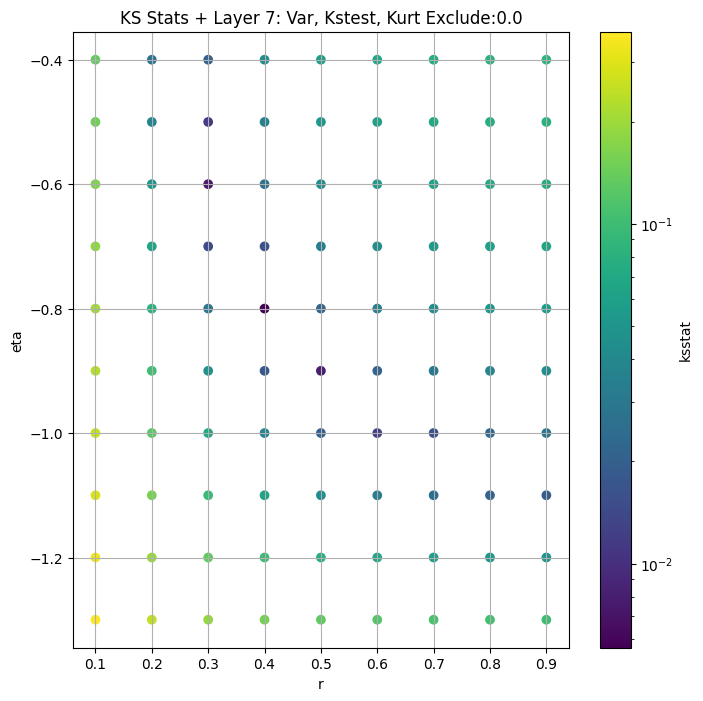

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00527019401014206 2.0576713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006172656806566812 1.977867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006565172675596531 1.9347866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006939616390794212 1.8980708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.007301550117894684 1.8652403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00825347469933456 1.8071622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009418604559882526 1.7560747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00917519444776338 1.7100185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009968543948491941 1.6678597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010151625051101454 1.6288364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010637907081238407 1.5260779
Number of samples: 100000, Without approximation : 28966912


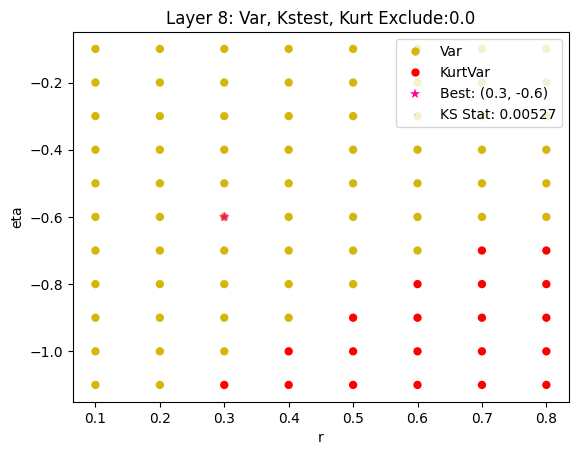

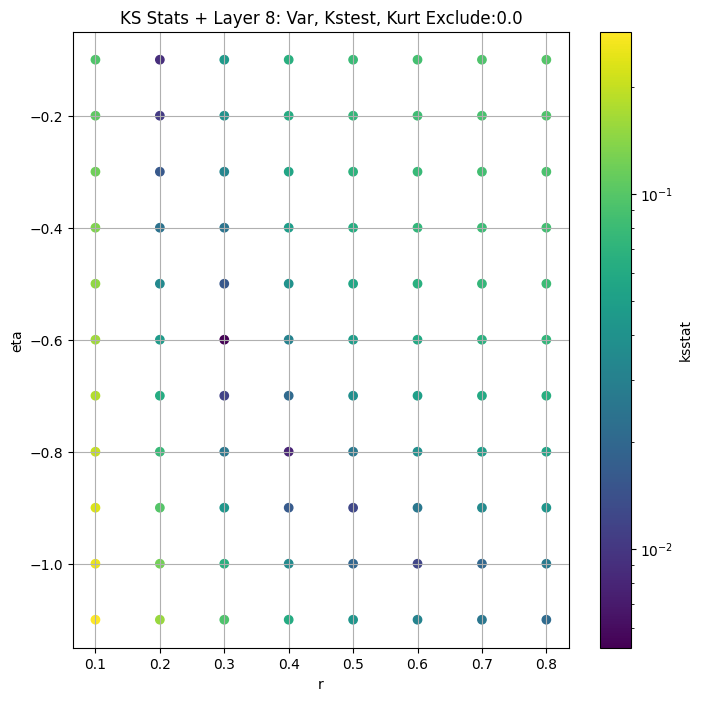

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.007345451819813498 0.47608036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.006161219501265691 0.45392653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.006238340299839364 0.44300458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.006548217064634487 0.43377066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006266652011574503 0.42557055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.007041120443299409 0.41119567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.008207445441058753 0.39866182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.009142929205970873 0.38744107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.009789594716974992 0.37722757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.010069988375798498 0.3678235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010066871429969981 0.34327343
Number of samples: 100000, Without approximation : 115867648


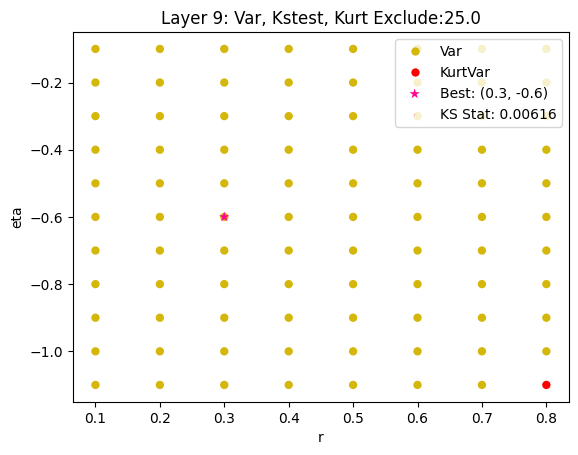

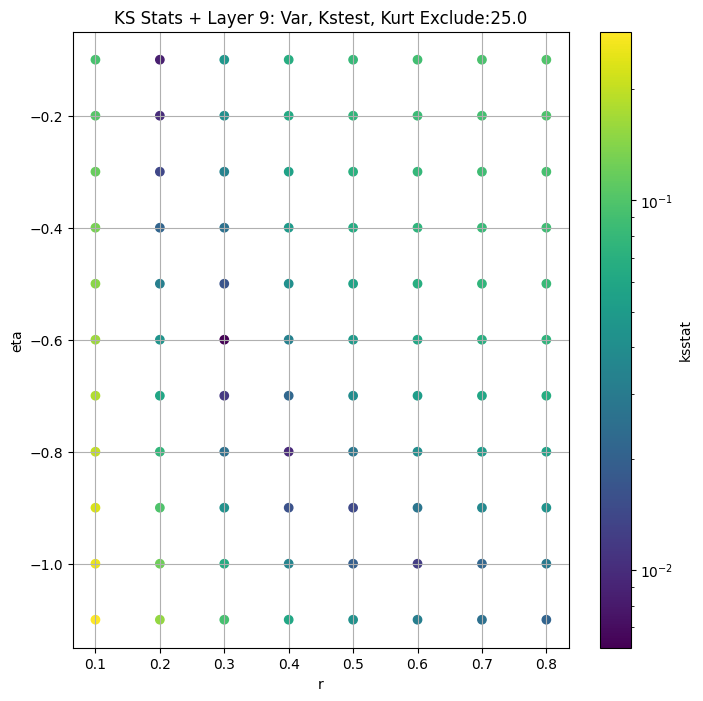

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.009780177149748936 0.11386799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.010249911732528871 0.10729978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.010912772892500477 0.104226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.010934084769197383 0.10166895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.010572614981609219 0.099423535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.01001694815076698 0.09554196


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.010347059223894783 0.09221267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.009753918991009913 0.08927014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.009498083655396783 0.08661995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.010298262913726375 0.08420211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.011430957620109594 0.07798064
Number of samples: 100000, Without approximation : 463470592


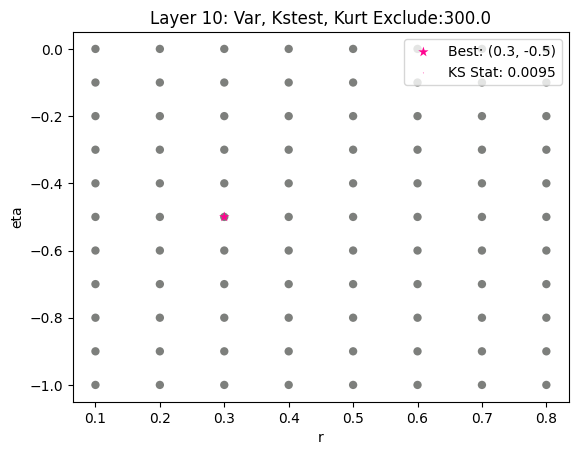

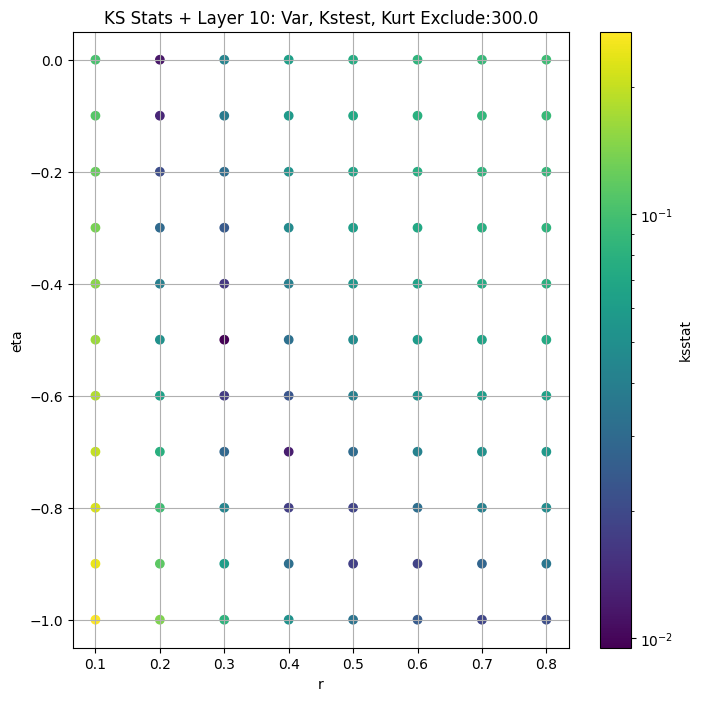

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8947.795000  8423.270000  9485.260000   1.786103    1.468954   
3      2426.993200  2289.952600  2569.244100   2.946779    2.434854   
4       662.267940   619.771800   706.498900   4.373578    3.584346   
5       169.682480   157.837700   182.347730   5.945025    4.603796   
6        40.756920    37.647247    44.079210   7.310348    5.609009   
7         9.277283     8.508139    10.167212   9.862153    6.618505   
8         2.057671     1.874289     2.295881  13.016489    7.337739   
9         0.476080     0.429436     0.549615  19.649048    8.255743   
10        0.113868     0.101202     0.135810  29.511372   10.192913   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.110565           7072             0.010593        3.4         -0.4   
3        3.534806          28288             0.005257        0.9         -0.6   
4        5.322586         113152             0.004464        0.8         -0.8   
5       10.143304         452608             0.004559        0.7         -0.9   
6       12.056628        1810432             0.005548        0.4         -0.7   
7       24.898218        7241728             0.005660        0.4         -0.8   
8       43.760510       28966912             0.005270        0.3         -0.6   
9       92.689224      115867648             0.006161        0.3         -0.6   
10     143.407300      463470592             0.009498        0.3         -0.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15412.241475                    25.0         8086.087000   
3        2306.624894                     0.0         2426.993200   
4         658.049291                    50.0          639.816200   
5         158.251727                    25.0          165.557850   
6           3.503944                     0.0           40.756920   
7           1.029127                     0.0            9.277283   
8           0.019229                     0.0            2.057671   
9           0.004242                    25.0            0.453927   
10          0.000619                   300.0            0.086620   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.02609460854028023, var: 6315.568359375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.022404887024766618, var: 6654.2177734375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.018511643633511543, var: 7040.59228515625


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.014013731692742448, var: 7500.47021484375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.010593492395898296, var: 8086.0869140625


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.012208206150170708, var: 8947.794921875
Number of samples: 7072, Without approximation : 7072


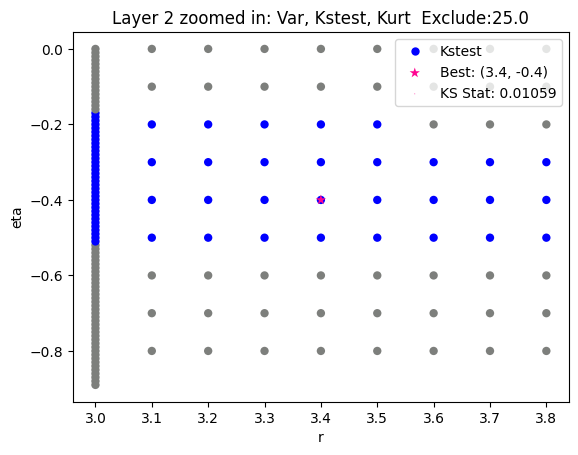

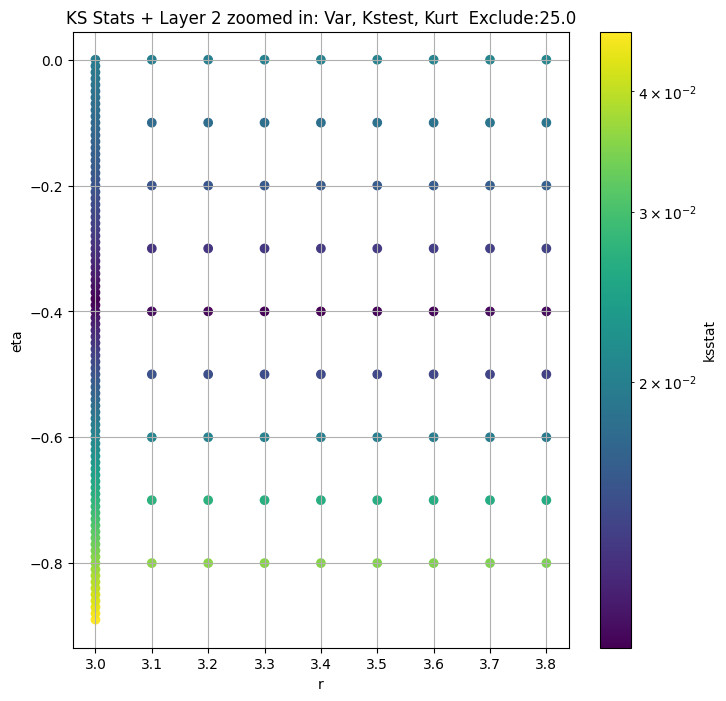

Layer 3


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.008596254796690461, var: 2140.92529296875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.0071467809451899456, var: 2194.1845703125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.005616551973327222, var: 2252.9599609375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.0051497402438772655, var: 2322.521240234375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004762571898626611, var: 2426.9931640625
Number of samples: 28288, Without approximation : 28288


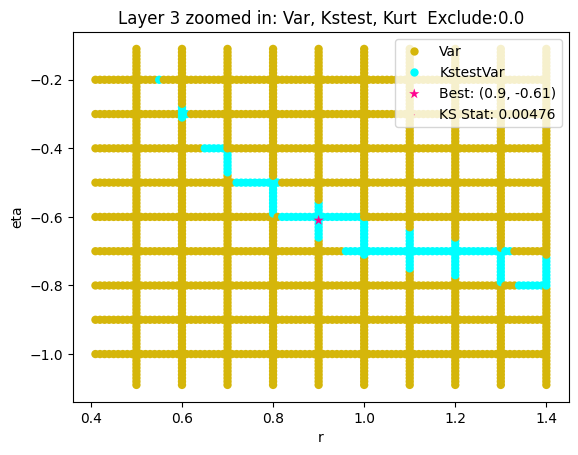

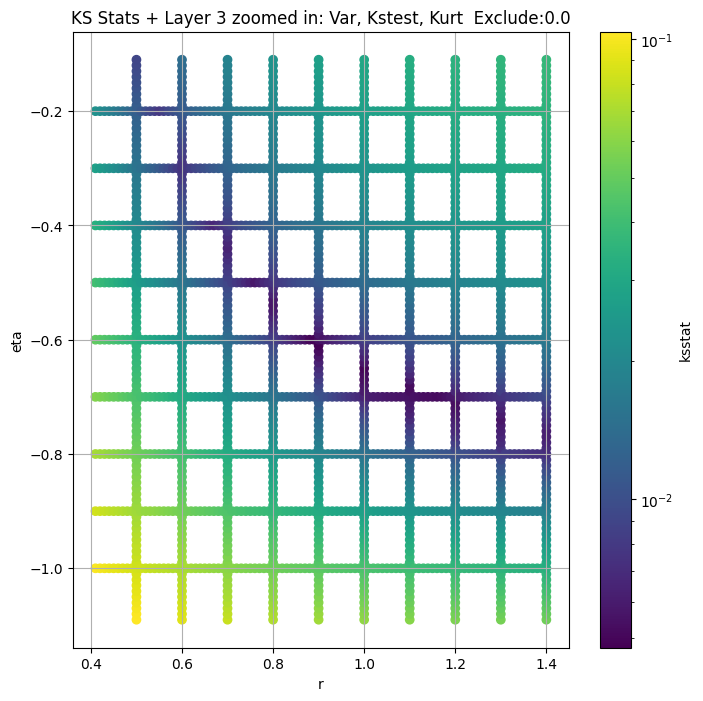

Layer 4


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + 100 = 150, ksstat: 0.0047925451759361914, var: 610.9536743164062


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + 75 = 125, ksstat: 0.004684483575858933, var: 617.290771484375


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + 50 = 100, ksstat: 0.00447778729234416, var: 624.0670166015625


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + 25 = 75, ksstat: 0.004449886669912417, var: 631.5083618164062


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + 0 = 50, ksstat: 0.00397312930900473, var: 639.8162231445312


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + -25 = 25, ksstat: 0.003880634968432717, var: 649.18603515625


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 50.0 + -50 = 0, ksstat: 0.0033038142599538523, var: 662.2679443359375
Number of samples: 100000, Without approximation : 113152


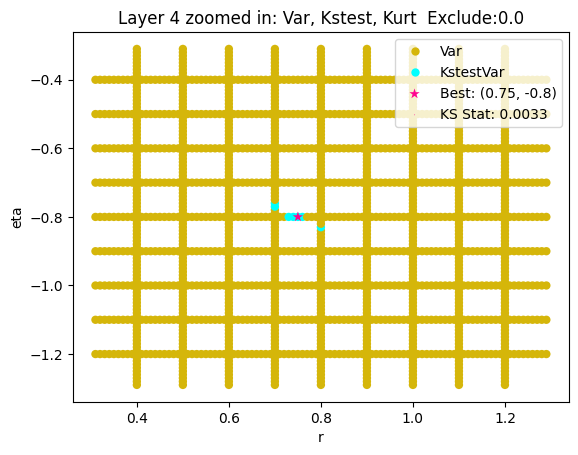

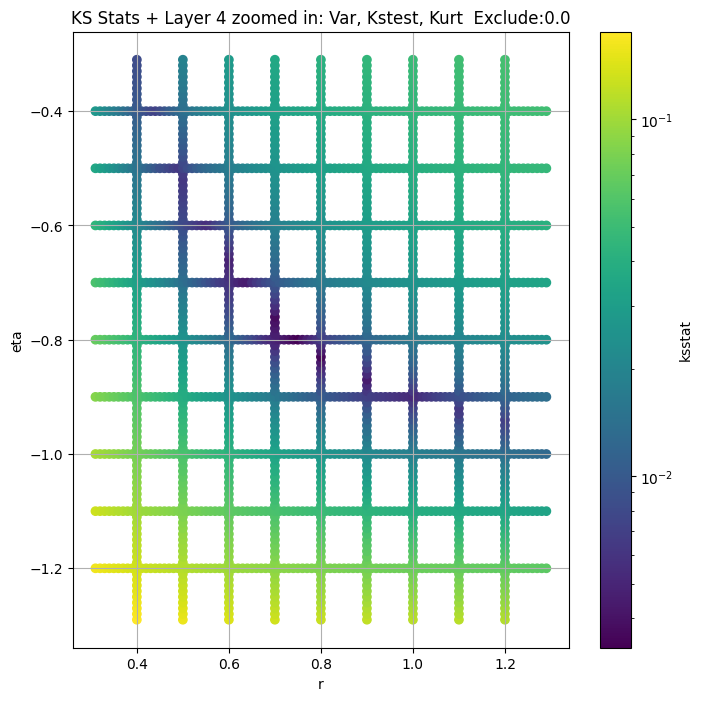

Layer 5


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.005968102326160185, var: 156.46141052246094


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.005499544497197584, var: 158.40240478515625


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.0053534972666116065, var: 160.49609375


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.004931956590842418, var: 162.82492065429688


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.004558673230634802, var: 165.55784606933594


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.004354537583411311, var: 169.68247985839844
Number of samples: 100000, Without approximation : 452608


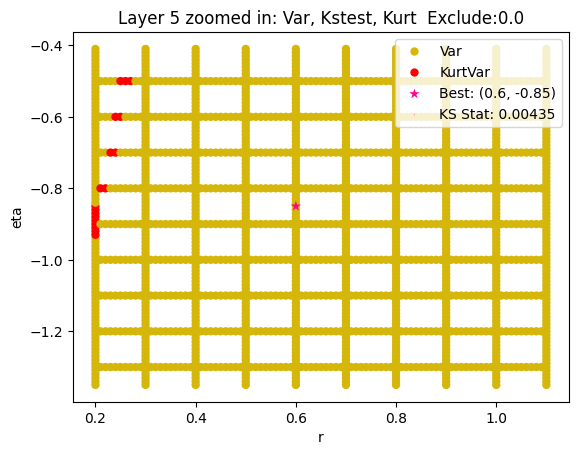

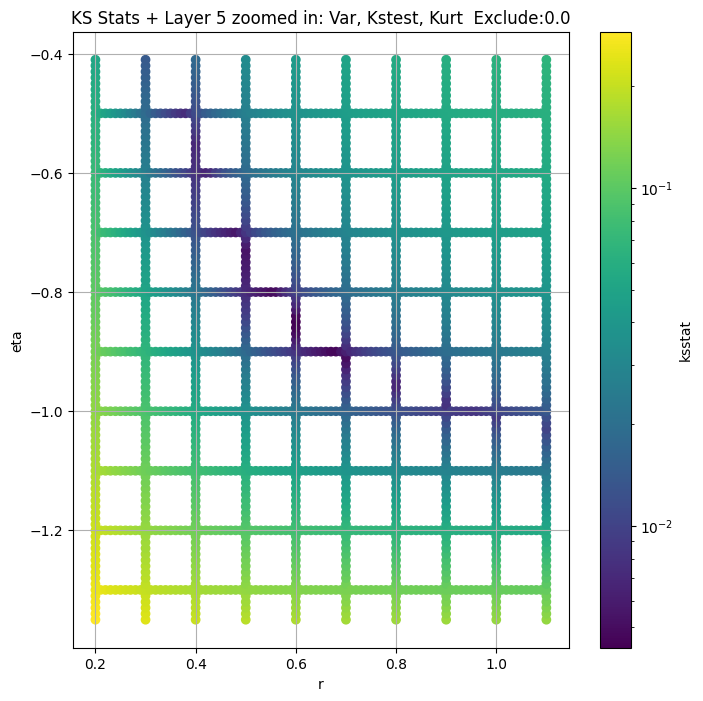

Layer 6


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.00570033072664855, var: 37.71795654296875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.005193947209685246, var: 38.273860931396484


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.004777945167403486, var: 38.894805908203125


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.004411635415772608, var: 39.62245559692383


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.004138706271511583, var: 40.756919860839844
Number of samples: 100000, Without approximation : 1810432


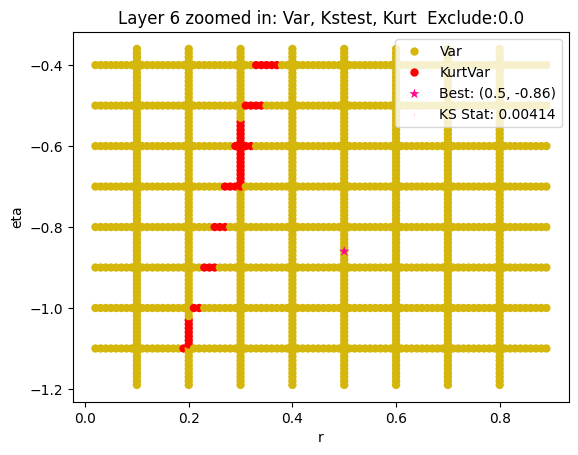

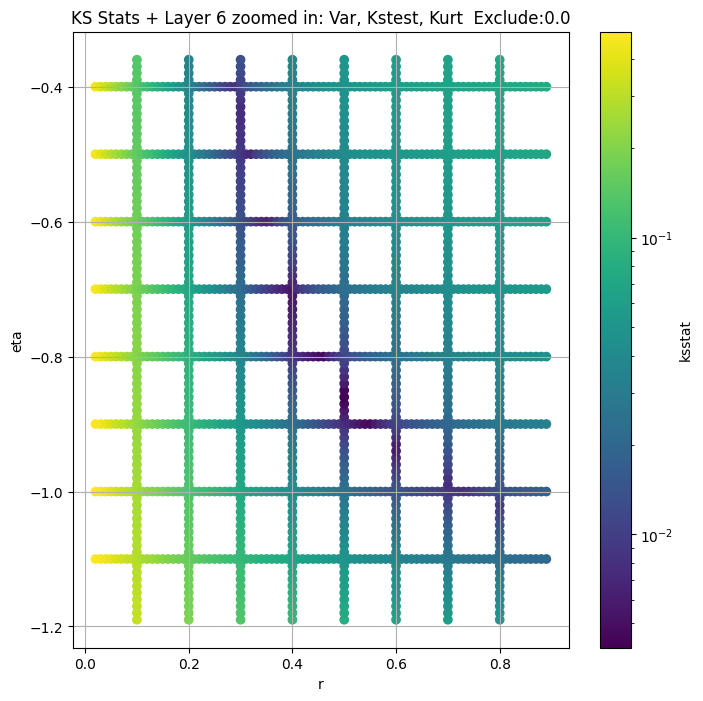

Layer 7


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.006414630845320124, var: 8.494418144226074


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.00616457437914375, var: 8.633245468139648


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.005843460185398851, var: 8.788098335266113


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.005364822865296381, var: 8.968994140625


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.004945718144717837, var: 9.27728271484375
Number of samples: 100000, Without approximation : 7241728


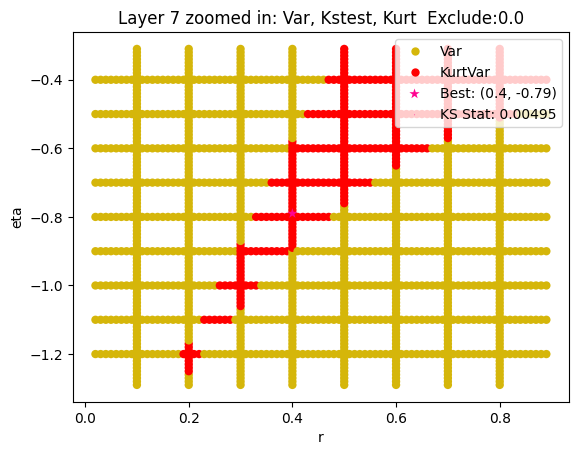

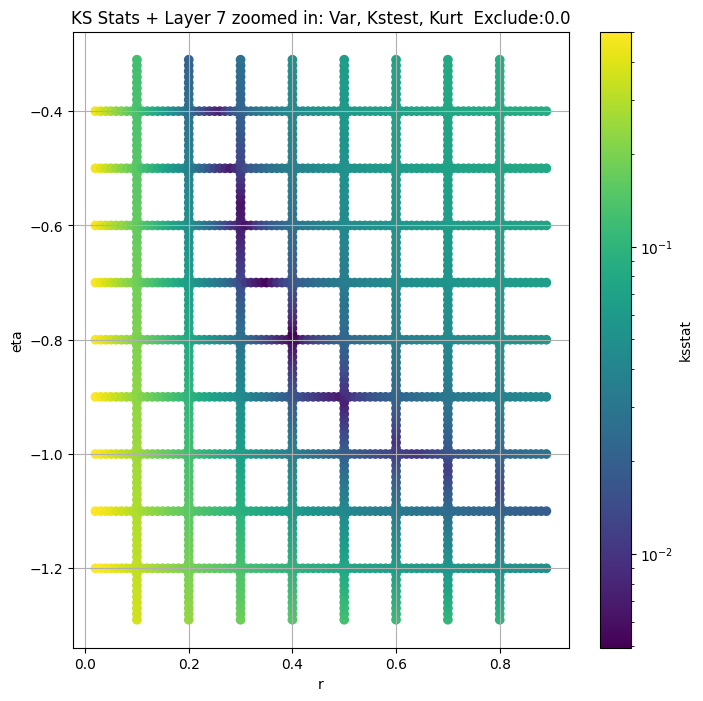

Layer 8


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.005925780583482233, var: 1.8652403354644775


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.005697556386037458, var: 1.8980708122253418


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.005829743878255245, var: 1.9347865581512451


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.005819917380874742, var: 1.9778670072555542


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.00527019401014206, var: 2.057671308517456
Number of samples: 100000, Without approximation : 28966912


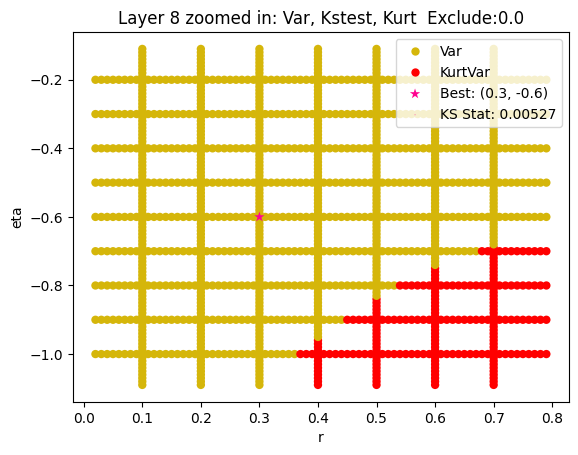

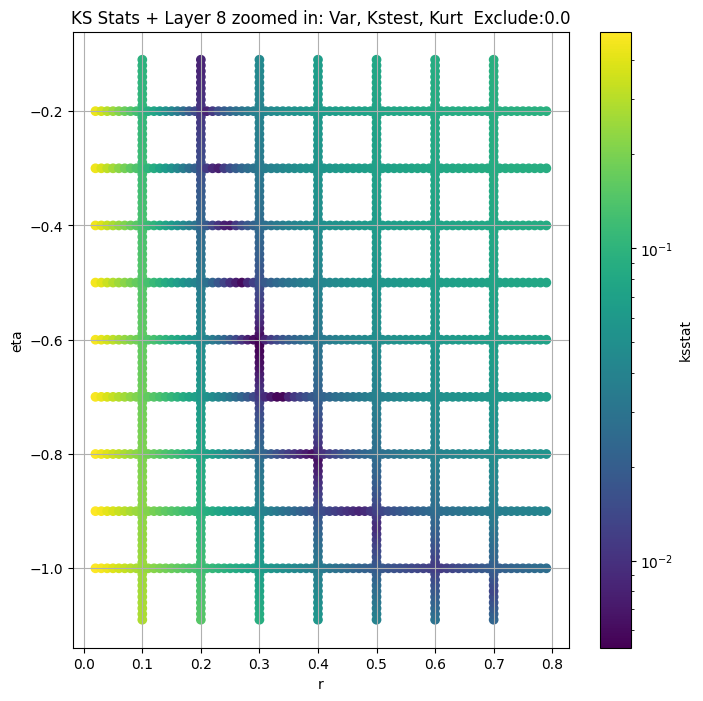

Layer 9


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.006064449006404127, var: 0.4181045889854431


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.006266652011574503, var: 0.425570547580719


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.006118310777649592, var: 0.43377065658569336


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.005431562922985411, var: 0.4430045783519745


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.005382577956055033, var: 0.45392653346061707


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.004694819063427502, var: 0.47608035802841187
Number of samples: 100000, Without approximation : 115867648


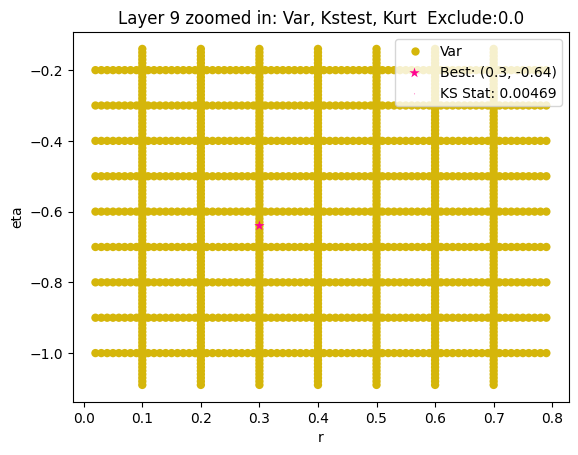

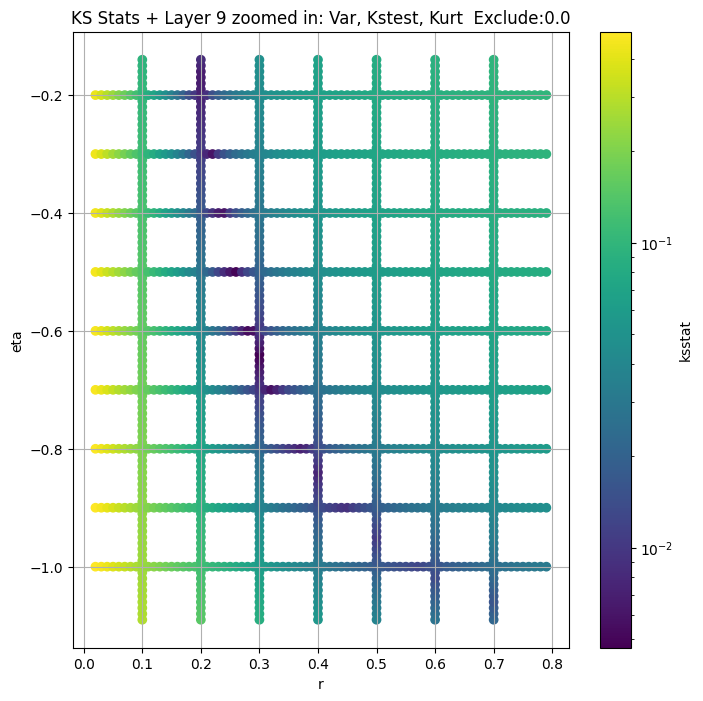

Layer 10


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + 100 = 400, ksstat: 0.009967398312818787, var: 0.08197543025016785


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + 75 = 375, ksstat: 0.009593869582335213, var: 0.08306701481342316


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + 50 = 350, ksstat: 0.00978381569359471, var: 0.0842021107673645


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + 25 = 325, ksstat: 0.009639295149046156, var: 0.08538486808538437


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + 0 = 300, ksstat: 0.009498083655396783, var: 0.08661995083093643


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + -25 = 275, ksstat: 0.0095425294173197, var: 0.08791285753250122


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + -50 = 250, ksstat: 0.009497652057486872, var: 0.08927013725042343


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + -75 = 225, ksstat: 0.009549867903491771, var: 0.09069998562335968


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 300.0 + -100 = 200, ksstat: 0.009451359877617138, var: 0.09221266955137253
Number of samples: 100000, Without approximation : 463470592


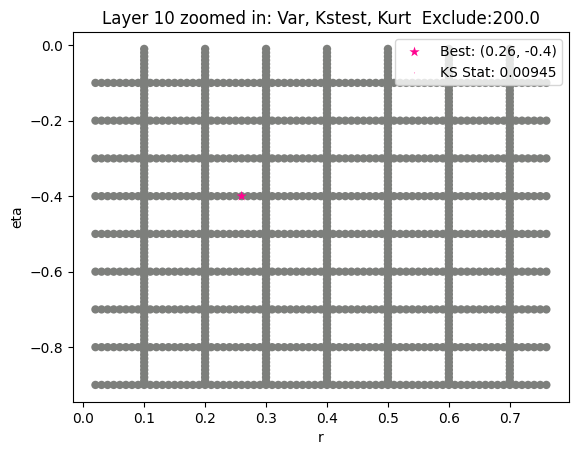

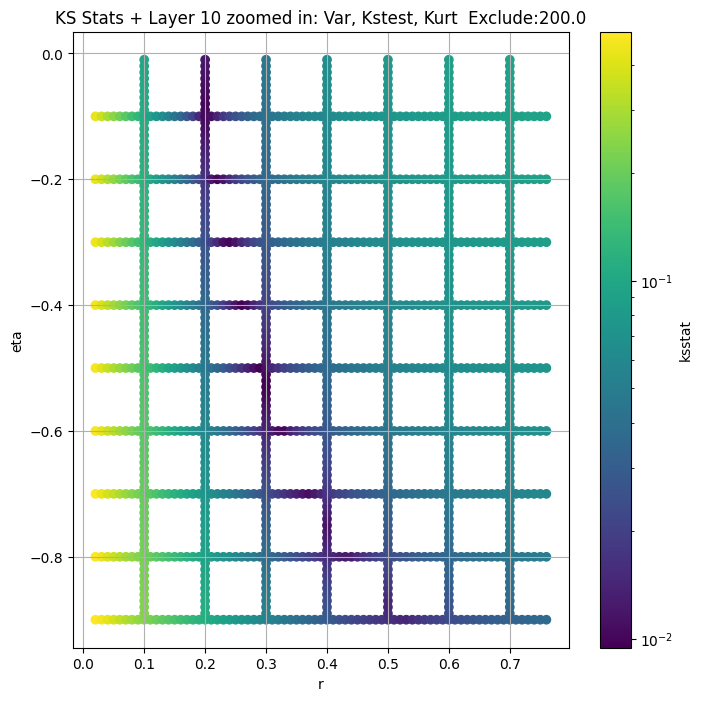

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8947.795000  8423.270000  9485.260000   1.786103    1.468954   
3      2426.993200  2289.952600  2569.244100   2.946779    2.434854   
4       662.267940   619.771800   706.498900   4.373578    3.584346   
5       169.682480   157.837700   182.347730   5.945025    4.603796   
6        40.756920    37.647247    44.079210   7.310348    5.609009   
7         9.277283     8.508139    10.167212   9.862153    6.618505   
8         2.057671     1.874289     2.295881  13.016489    7.337739   
9         0.476080     0.429436     0.549615  19.649048    8.255743   
10        0.113868     0.101202     0.135810  29.511372   10.192913   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.110565           7072             0.010593        3.4         -0.4   
3        3.534806          28288             0.005257        0.9         -0.6   
4        5.322586         113152             0.004464        0.8         -0.8   
5       10.143304         452608             0.004559        0.7         -0.9   
6       12.056628        1810432             0.005548        0.4         -0.7   
7       24.898218        7241728             0.005660        0.4         -0.8   
8       43.760510       28966912             0.005270        0.3         -0.6   
9       92.689224      115867648             0.006161        0.3         -0.6   
10     143.407300      463470592             0.009498        0.3         -0.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15412.241475                    25.0         8086.087000   
3        2306.624894                     0.0         2426.993164   
4         658.049291                    50.0          662.267944   
5         158.251727                    25.0          169.682480   
6           3.503944                     0.0           40.756920   
7           1.029127                     0.0            9.277283   
8           0.019229                     0.0            2.057671   
9           0.004242                    25.0            0.476080   
10          0.000619                   300.0            0.092213   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.010593    3.40     -0.40   
3                     0.008069          0.004763    0.90     -0.61   
4                     0.004036          0.003304    0.75     -0.80   
5                     0.002018          0.004355    0.60     -0.85   
6                     0.001009          0.004139    0.50     -0.86   
7                     0.000505          0.004946    0.40     -0.79   
8                     0.000252          0.005270    0.30     -0.60   
9                     0.000126          0.004695    0.30     -0.64   
10                    0.000063          0.009451    0.26     -0.40   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      15412.241475                 25.0        15912  
3       2334.344146                  0.0        80554  
4        603.918771                  0.0       169728  
5        101.099474                  0.0        95472  
6         13.965502                  0.0       113152  
7          1.001937                  0.0        76461  
8          0.019229                  0.0        63648  
9          0.004988                  0.0        84864  
10         0.000127                200.0        21216

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

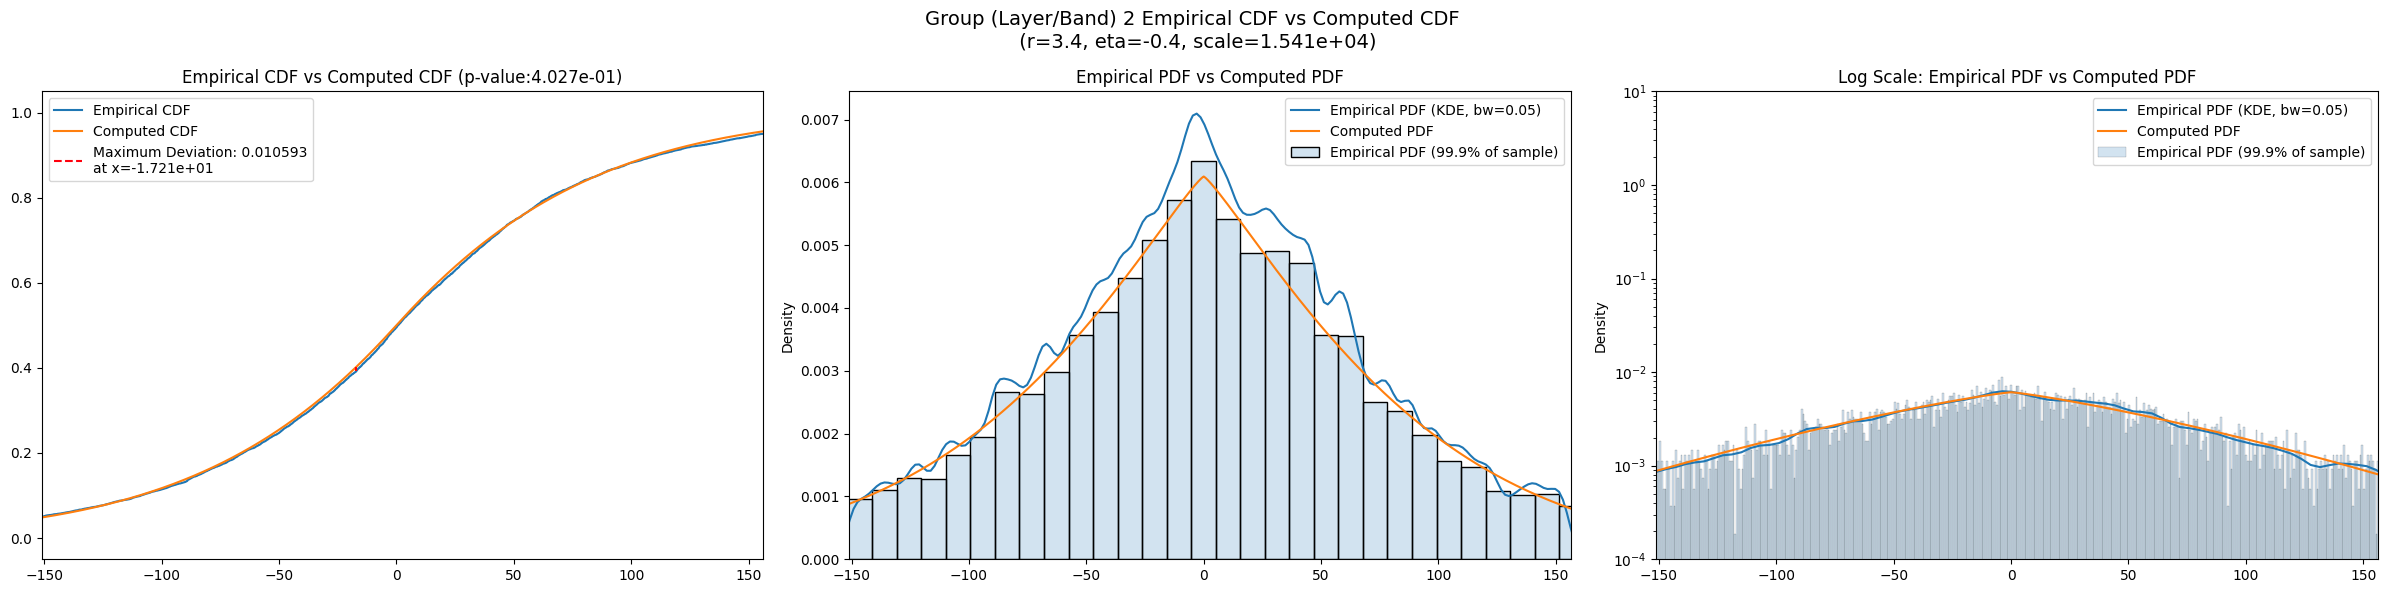

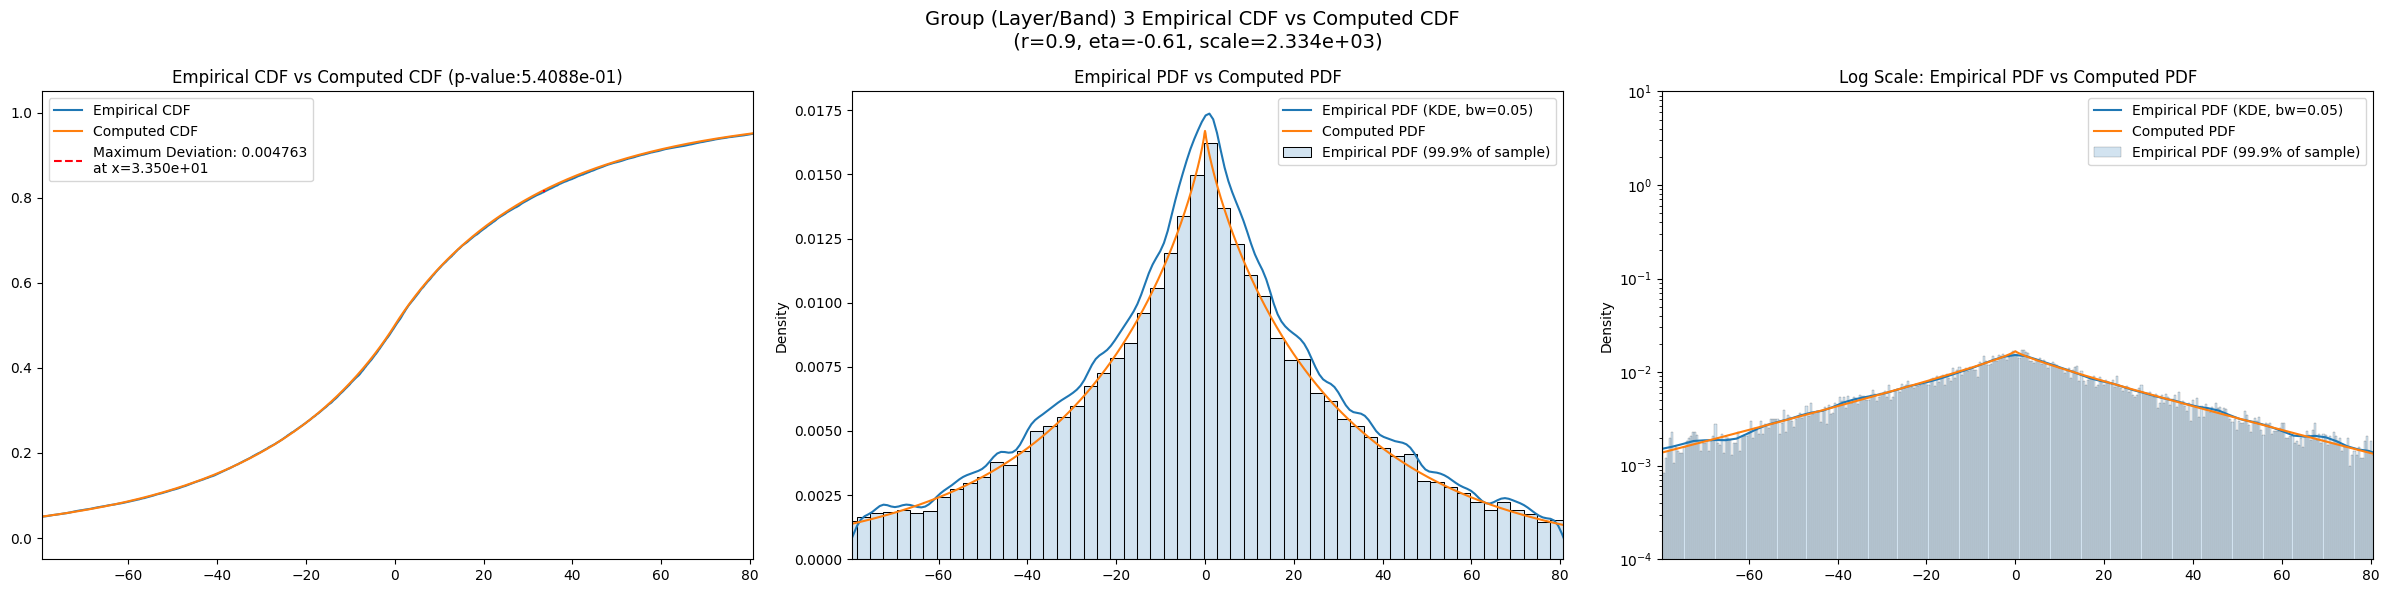

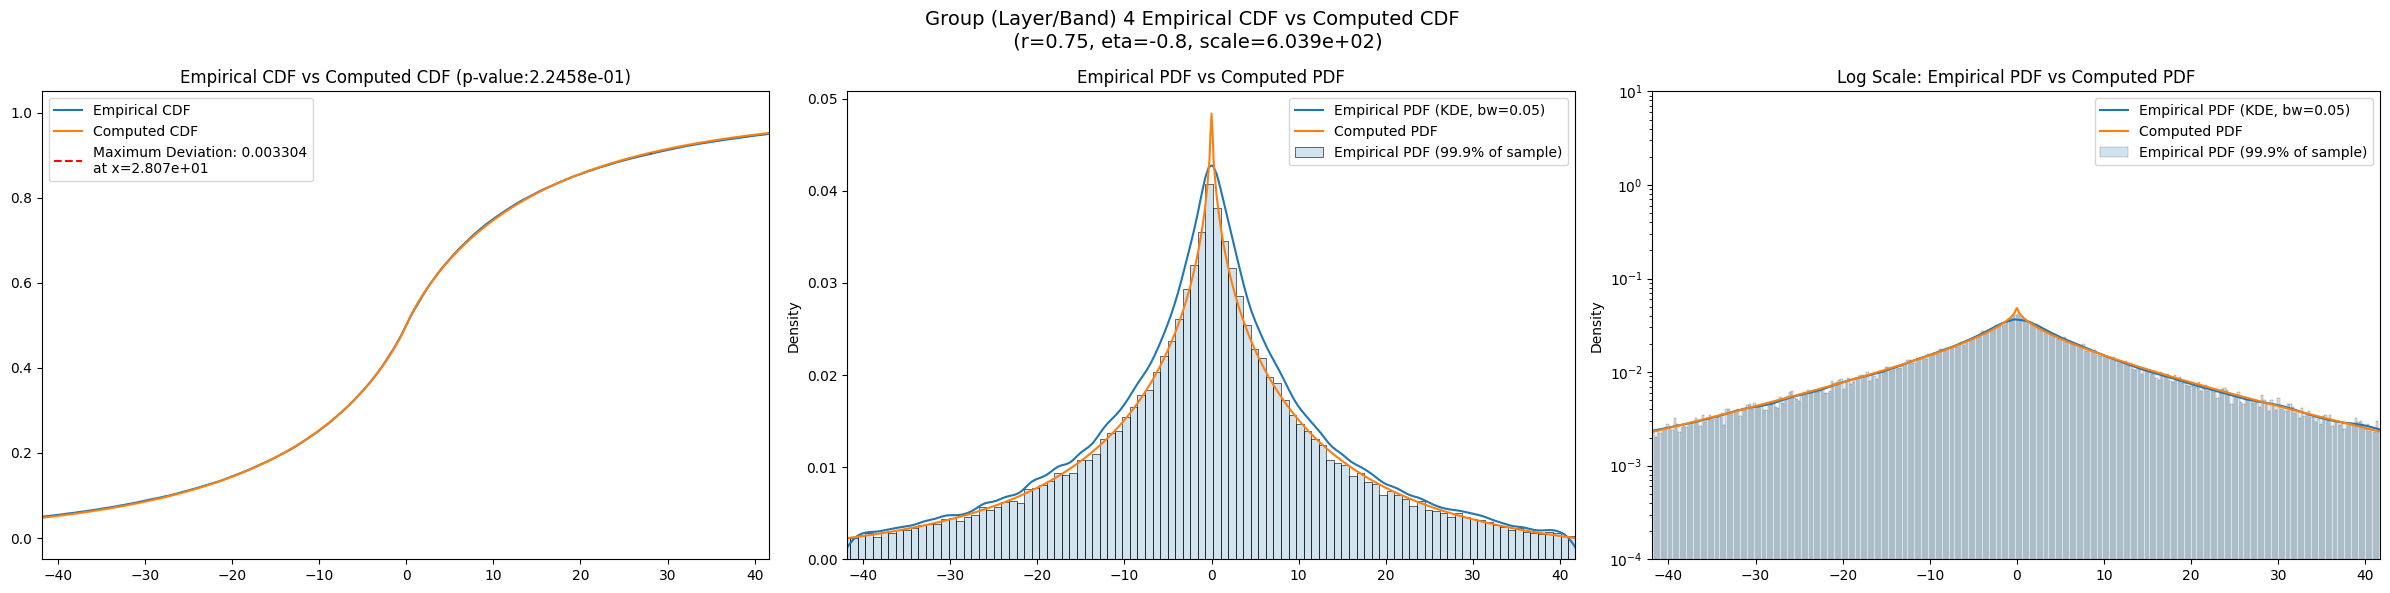

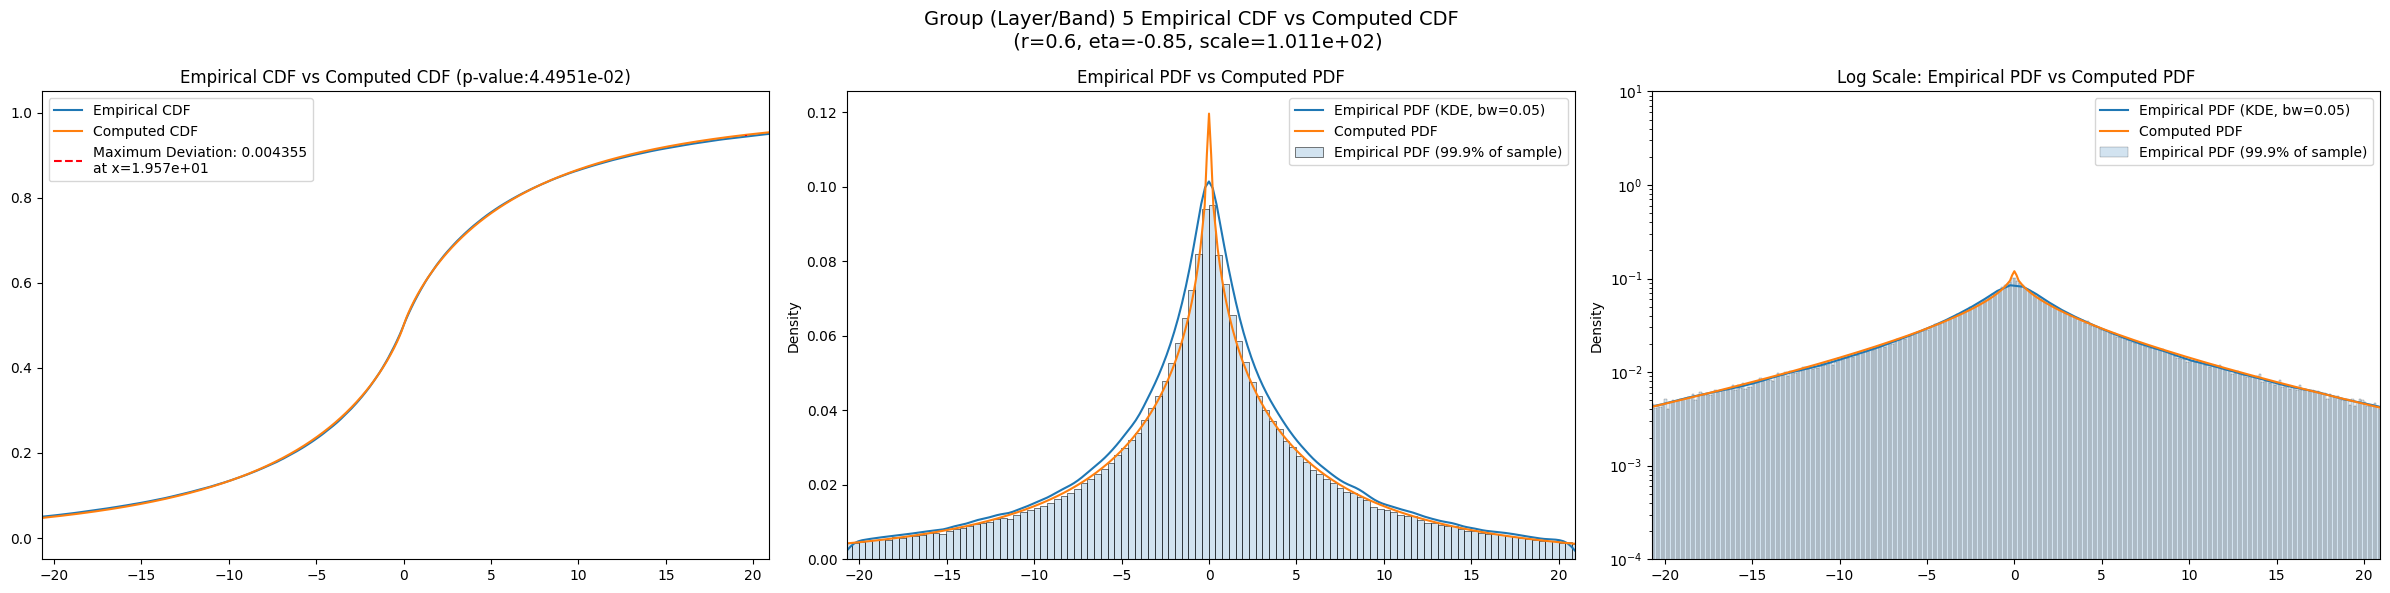

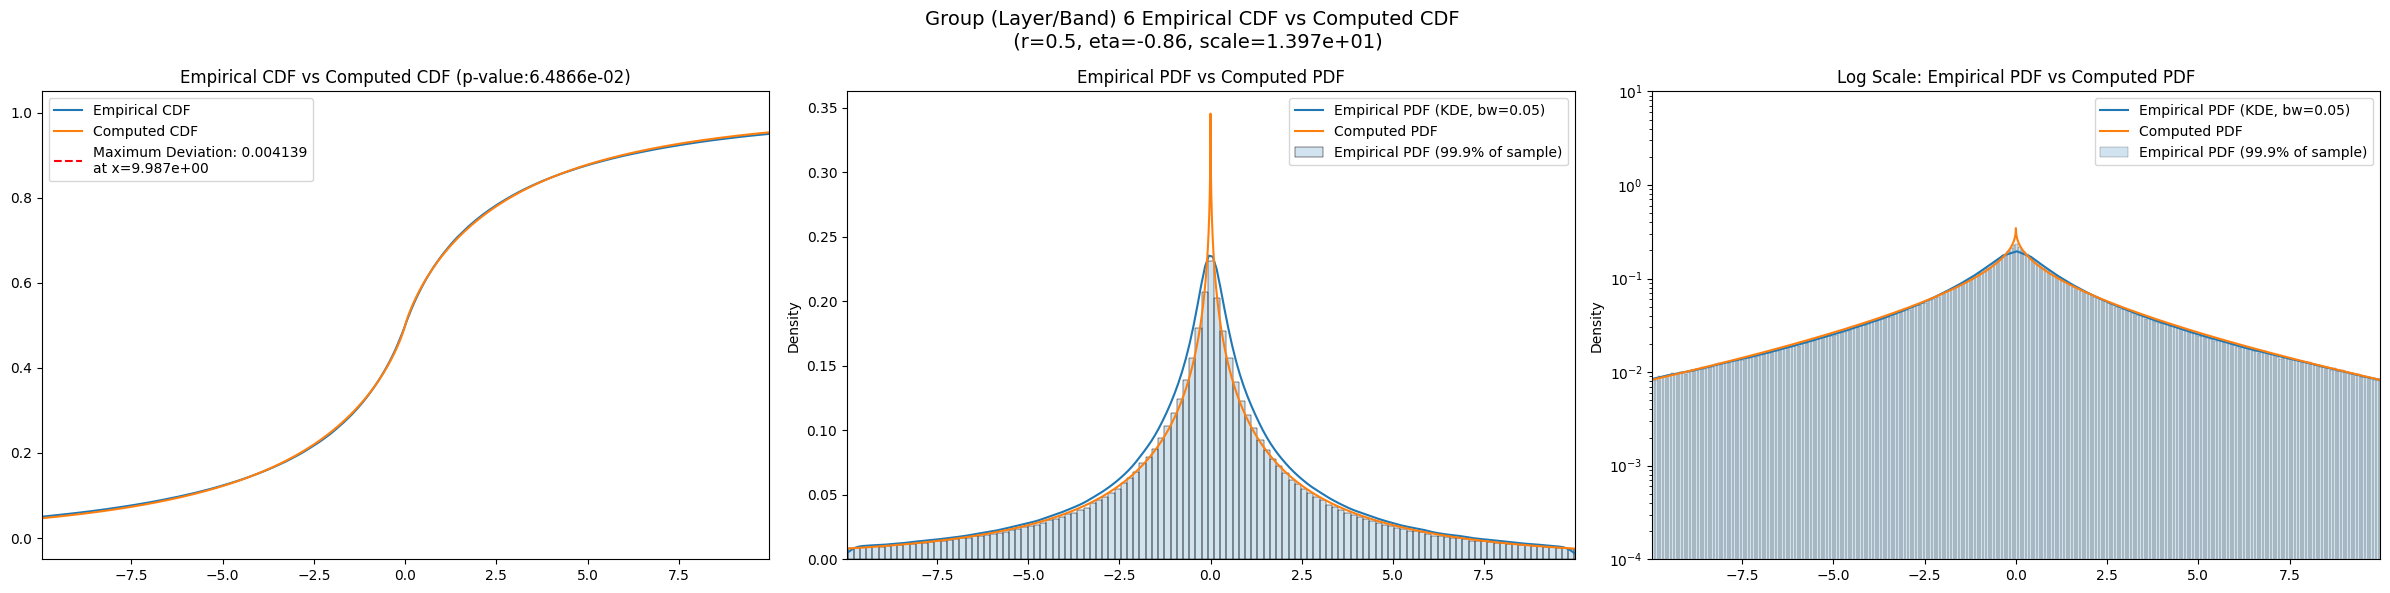

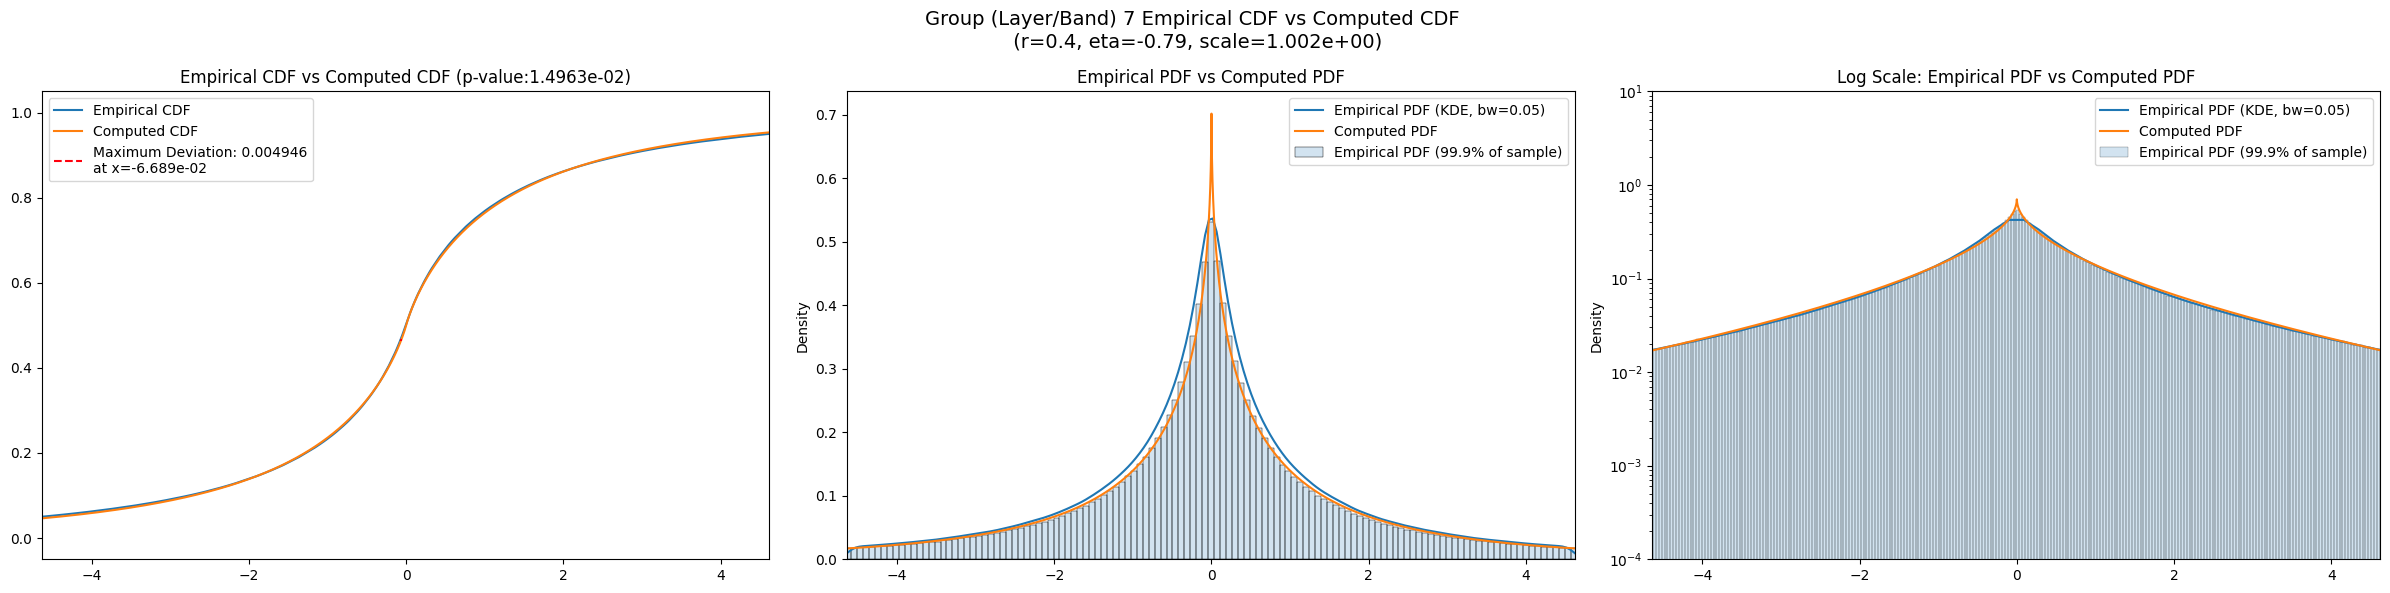

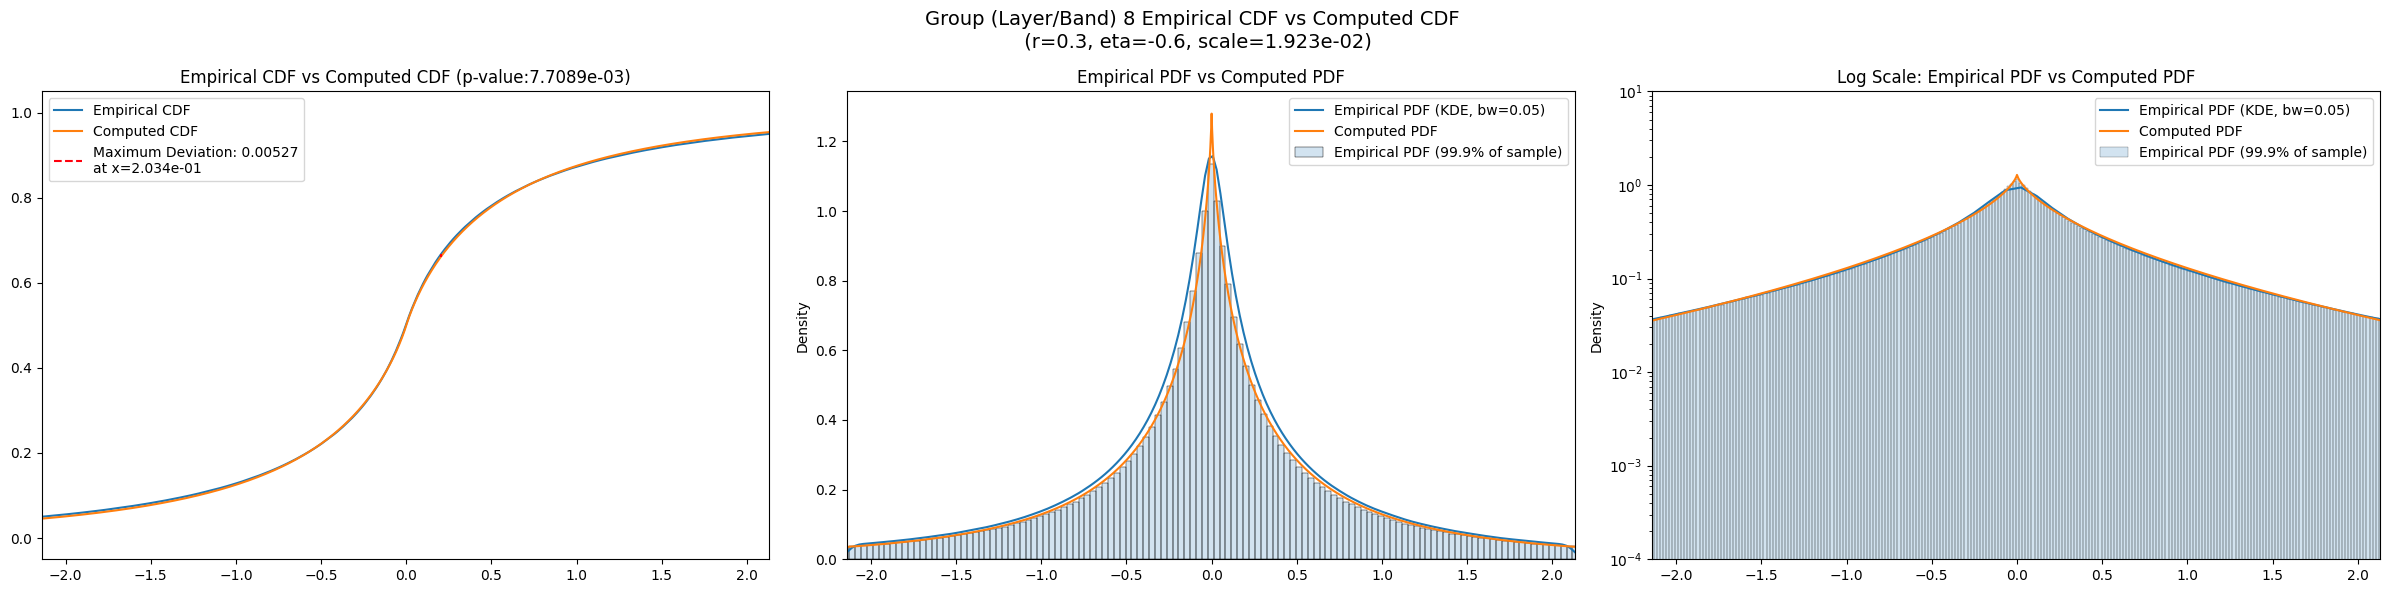

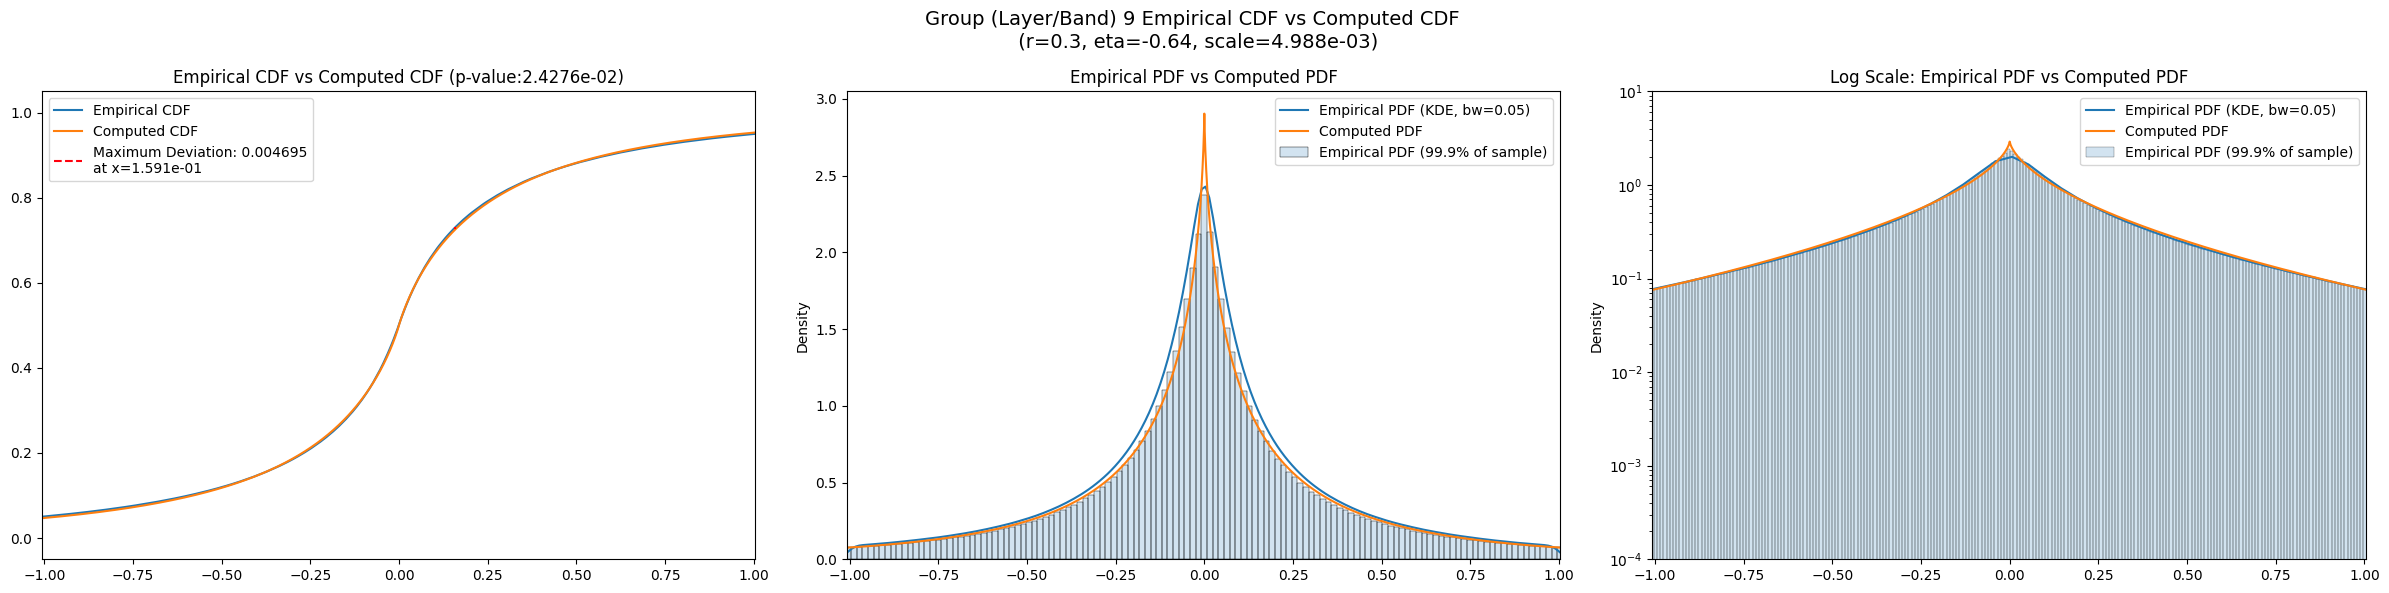

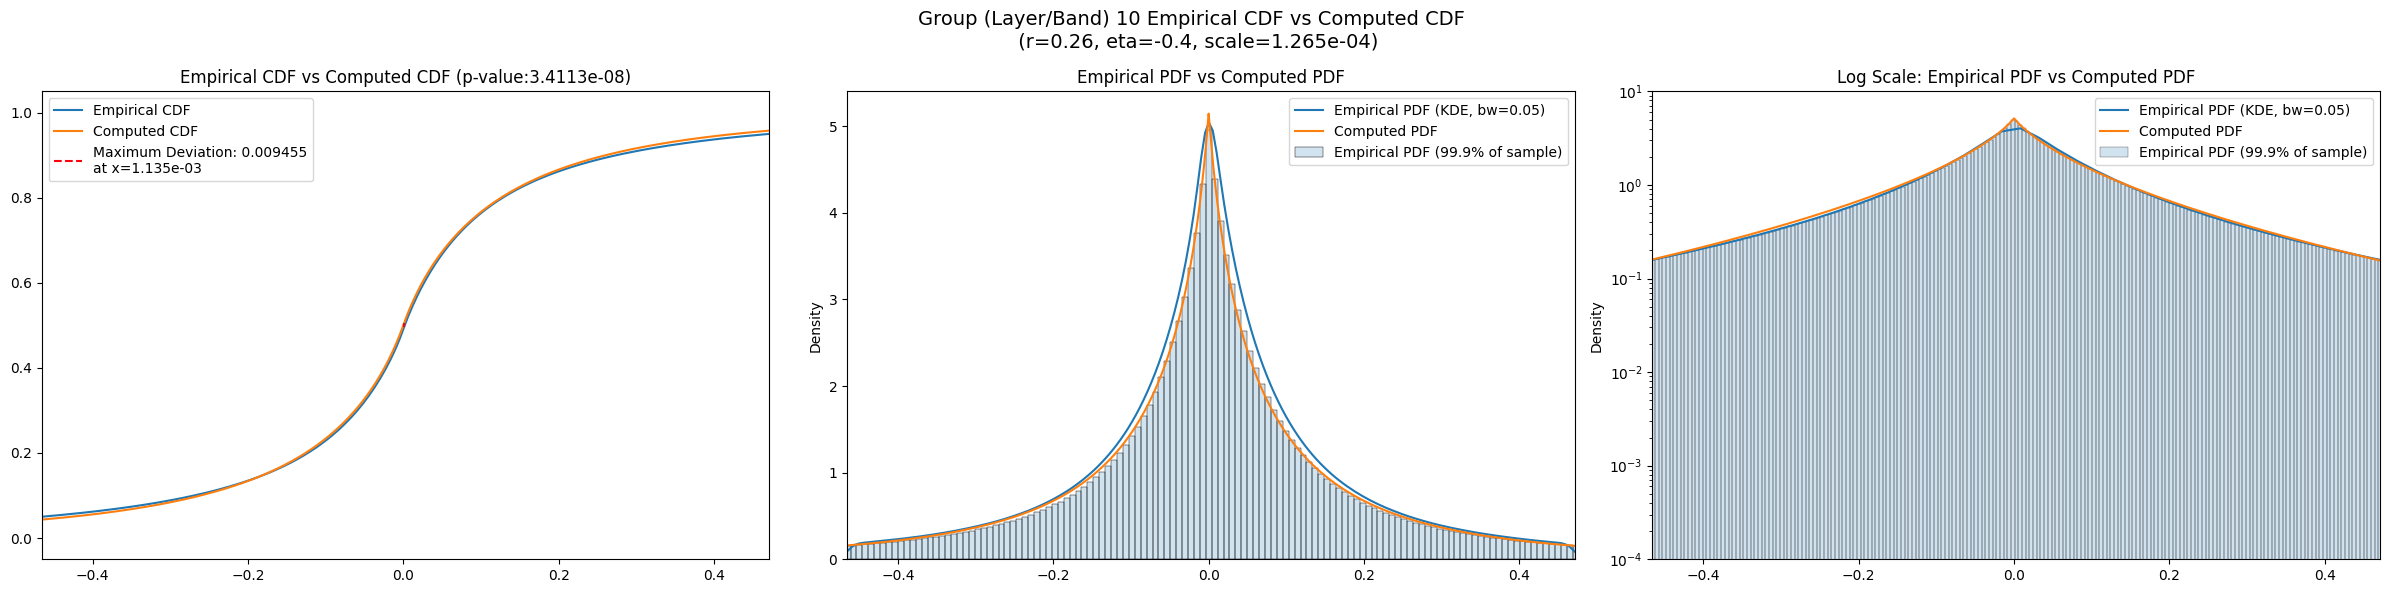

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8947.795000  8423.270000  9485.260000   1.786103    1.468954   
3      2426.993200  2289.952600  2569.244100   2.946779    2.434854   
4       662.267940   619.771800   706.498900   4.373578    3.584346   
5       169.682480   157.837700   182.347730   5.945025    4.603796   
6        40.756920    37.647247    44.079210   7.310348    5.609009   
7         9.277283     8.508139    10.167212   9.862153    6.618505   
8         2.057671     1.874289     2.295881  13.016489    7.337739   
9         0.476080     0.429436     0.549615  19.649048    8.255743   
10        0.113868     0.101202     0.135810  29.511372   10.192913   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.110565           7072             0.010593        3.4         -0.4   
3        3.534806          28288             0.005257        0.9         -0.6   
4        5.322586         113152             0.004464        0.8         -0.8   
5       10.143304         452608             0.004559        0.7         -0.9   
6       12.056628        1810432             0.005548        0.4         -0.7   
7       24.898218        7241728             0.005660        0.4         -0.8   
8       43.760510       28966912             0.005270        0.3         -0.6   
9       92.689224      115867648             0.006161        0.3         -0.6   
10     143.407300      463470592             0.009498        0.3         -0.5   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       80.697400              0.026047          1.335130e-04   
3      ...       38.079700              0.035495          2.121220e-31   
4      ...       17.716100              0.045430         2.258830e-203   
5      ...        8.140130              0.052718          0.000000e+00   
6      ...        3.667960              0.056735          0.000000e+00   
7      ...        1.636090              0.059446          0.000000e+00   
8      ...        0.748525              0.060041          0.000000e+00   
9      ...        0.350232              0.060172          0.000000e+00   
10     ...        0.163754              0.059414          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          73.865800             0.016005         5.281830e-02  58.764000   
3          33.061400             0.008903         2.242200e-02  27.409400   
4          15.446800             0.017820         1.216920e-31  12.488900   
5           7.101230             0.025108        2.602200e-248   5.671310   
6           3.204360             0.029473         0.000000e+00   2.541160   
7           1.429750             0.032515         0.000000e+00   1.127220   
8           0.654342             0.033089         0.000000e+00   0.516160   
9           0.307169             0.033118         0.000000e+00   0.242325   
10          0.143695             0.032665         0.000000e+00   0.112554   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.016851   3.563590e-02          4.026957e-01  
3           0.015319   3.389630e-06          5.408797e-01  
4           0.021425   1.493940e-45          1.686705e-01  
5           0.027347  1.732060e-294          7.001731e-08  
6           0.030826   0.000000e+00          2.313602e-27  
7           0.033528   0.000000e+00         2.775323e-154  
8           0.033961   0.000000e+00          0.000000e+00  
9           0.033297   0.000000e+00          0.000000e+00  
10          0.033055   0.000000e+00          0.000000e+00  

[9 rows x 30 

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.010593                 0.016126          0.010593   
3                 0.005257                 0.008069          0.004763   
4                 0.004464                 0.004036          0.003304   
5                 0.004559                 0.002018          0.004355   
6                 0.005548                 0.001009          0.004139   
7                 0.005660                 0.000505          0.004946   
8                 0.005270                 0.000252          0.005270   
9                 0.006161                 0.000126          0.004695   
10                0.009498                 0.000063          0.009451   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.026047             0.016005       0.016851  
3                  0.035495             0.008903       0.015319  
4                  0.045430             0.017820       0.021425  
5                  0.052718             0.025108       0.027347  
6                  0.056735             0.029473       0.030826  
7                  0.059446             0.032515       0.033528  
8                  0.060041             0.033089       0.033961  
9                  0.060172             0.033118       0.033297  
10                 0.059414             0.032665       0.033055

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8086.087000          0.010593    3.40     -0.40  15412.241475   
3             2426.993164          0.004763    0.90     -0.61   2334.344146   
4              662.267944          0.003304    0.75     -0.80    603.918771   
5              169.682480          0.004355    0.60     -0.85    101.099474   
6               40.756920          0.004139    0.50     -0.86     13.965502   
7                9.277283          0.004946    0.40     -0.79      1.001937   
8                2.057671          0.005270    0.30     -0.60      0.019229   
9                0.476080          0.004695    0.30     -0.64      0.004988   
10               0.092213          0.009451    0.26     -0.40      0.000127   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                   200.0